# Interconnection Queues Analysis

How likely is each project in the queue to be completed?

In [1]:
import gridstatusio as gs
import gridstatus as g
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import datetime
import requests
import Grid_Status_Functions as gf

In [121]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

In [3]:
all_qs = pd.read_csv('int_qs.csv')

## CAISO

In [73]:
#Load subset of queues dataset

caiso = all_qs[all_qs["ISO"] == 'California ISO']

In [74]:
#Drop Unnecessary Columns

caiso = caiso.drop(columns=["ISO","State","Summer Capacity (MW)","Winter Capacity (MW)",
                            "ISO","Unnamed: 0","Interconnecting Entity","County",
                           "Withdrawn Date","Withdrawal Comment"])

In [75]:
#Create Project Length column

caiso["Queue Date"] = pd.to_datetime(caiso["Queue Date"])
caiso["Actual Completion Date"] = caiso["Actual Completion Date"].fillna(caiso["Proposed Completion Date"])
caiso = caiso[caiso["Actual Completion Date"].isna()==False]
caiso["Actual Completion Date"] = pd.to_datetime(caiso["Actual Completion Date"])
caiso["Project Length"] = (caiso["Actual Completion Date"] - caiso["Queue Date"]).dt.days
caiso = caiso.drop(columns=["Actual Completion Date","Queue Date","Proposed Completion Date"])

In [76]:
#Format Generation Types Column

caiso = caiso[caiso["Generation Type"] != "Other"]
caiso["Generation Type"] = caiso["Generation Type"].str.lower()
caiso["Generation Type"] = caiso["Generation Type"].str.replace('\+', '', regex=True)
caiso["Generation Type"] = caiso["Generation Type"].str.replace("turbine","")

In [77]:
#Create dummy columns for each generation type

gentypes = set(caiso["Generation Type"])
types_list = []
for g in gentypes:
    for h in g.split():
        types_list.append(h)
gentypes = set(types_list)
gentypes = list(gentypes)
gentypes.remove('solar')
gentypes.remove('engine')
gentypes.remove('combined')
gentypes.remove('other')
# gentypes

for g in gentypes:
    caiso[g] = caiso["Generation Type"].str.contains(g)

In [78]:
#We could add column

# caiso["Renewable"] = caiso["Generation Type"].str.contains("wind|photovoltaic|hydro|solarthermal")
# caiso["Non-Renewable"] = caiso["Generation Type"].str.contains("steam|gas|combinedcycle|combustion|cogeneration|reciprocatingengine")

In [79]:
#Extract kilavolt info from Interconnection Loaction column and create kv column

caiso["Interconnection Location"] = caiso["Interconnection Location"].str.lower().str.replace(" ","")
caiso['kv'] = caiso['Interconnection Location'].str.extract('(\d+)kv')
caiso.loc[caiso['kv'].str.len() > 3, 'kv'] = caiso.loc[caiso['kv'].str.len() > 3, 'kv'].str[1:] #for mistakenly identified voltages
#caiso['kv'] = caiso['kv'].fillna('x')

In [80]:
#Extract interconnection method from Interconnection Location column and create new dummy columns for each method

caiso["Line"] = caiso['Interconnection Location'].str.contains('line')
caiso["Bus"] = caiso['Interconnection Location'].str.contains('bus')
caiso["Substation"] = caiso['Interconnection Location'].str.contains('substation')

In [81]:
#Create dummy variables for Transmission Owner and kv

to_dummies = pd.get_dummies(caiso['Transmission Owner'], prefix='TO', prefix_sep='_')
kv_dummies = pd.get_dummies(caiso['kv'], prefix='kv', prefix_sep='_')
caiso = pd.concat([caiso, to_dummies, kv_dummies], axis=1)

In [87]:
#Dataframe with all dummies, excluding the target variable, "Status" for modeling

model_df = caiso.drop(columns=['Queue ID', 'Project Name', 'Interconnection Location',
       'Transmission Owner', 'Generation Type','kv'])
model_df

,Capacity (MW),Status,Project Length,wind,cycle,steam,combustion,cogeneration,gas,photovoltaic,...,kv_270,kv_345,kv_360,kv_500,kv_55,kv_60,kv_66,kv_69,kv_70,kv_8
4253,38.00,ACTIVE,2599,True,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4254,193.80,ACTIVE,6795,True,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4255,73.27,ACTIVE,6544,False,False,True,False,False,False,False,...,0,0,0,0,0,0,0,0,1,0
4256,500.00,ACTIVE,8594,False,False,False,False,False,False,False,...,0,0,0,1,0,0,0,0,0,0
4257,150.00,ACTIVE,6582,True,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6526,100.00,WITHDRAWN,1143,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
6527,150.00,WITHDRAWN,1143,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,1,0,0
6528,50.00,WITHDRAWN,1508,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,1,0,0
6529,250.00,WITHDRAWN,729,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0


In [174]:
#Split the active projects from the completed/withdraawn projects to first analyze the completed/withdrawn projects

active = model_df[model_df["Status"] == "ACTIVE"]
inactive = model_df[model_df["Status"] != "ACTIVE"]

#Create X and y for model
X = inactive.drop(columns="Status").astype('float64')
y = pd.get_dummies(inactive["Status"]).drop(columns='WITHDRAWN').rename(columns={'COMPLETED':'Status'}).astype('float64')

In [223]:
#Split data for models

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42)

In [190]:
#Need to make sure that all vectors are floats, not categories
y_train

,Status
5929,0.0
5175,0.0
5709,0.0
4902,1.0
5118,0.0
...,...
5866,0.0
6031,0.0
5589,0.0
6196,0.0


In [225]:
#Normalize data because we incorporate categorical and numerical variables, all measured differently
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Create and fit logistic regression model
model = LogisticRegression(penalty='l2')
model.fit(X_train, y_train.values.ravel())

#Make predictions on test set
predictions = model.predict(X_test)

#Evaluate model performance
accuracy = model.score(X_test, y_test)

In [226]:
#To get p values:

# add a column of ones for the intercept in X_test
X_test = sm.add_constant(X_test) #but now we're saying this doesn't work

# predict the probabilities of y_test using X_test and logreg
y_pred = model.predict_proba(X_test)[:,1]

In [229]:
#Model accuracy

accuracy

0.8969359331476323

In [230]:
# get the coefficients and intercept

coef = model.coef_
intercept = model.intercept_
intercept

array([-2.80243112])

In [231]:
# create a dataframe of the feature names and coefficients. 
#There's a lot of features for this to be interpretable

feature_names = list(model_inactive.drop(columns='Status',axis=1).columns)
coef_df = pd.DataFrame({"feature": feature_names, "coefficient": coef[0]})
coef_df                   

,feature,coefficient
0,Capacity (MW),-1.118709
1,Project Length,0.778763
2,wind,-0.174802
3,cycle,0.172529
4,steam,-0.103542
5,combustion,-0.007533
6,cogeneration,0.181677
7,gas,0.085484
8,photovoltaic,-0.122386
9,storage,-0.982870


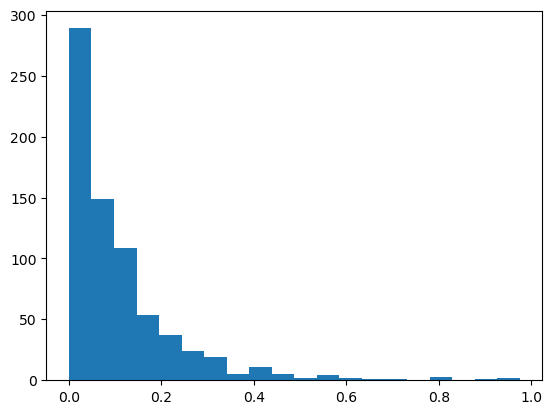

In [227]:
#These are the projects that have over 50% probability of being completed according to the model. 
#Let's join this with the original df.

y_pred = pd.DataFrame(y_pred)
y_pred[y_pred[0] > .3]
plt.hist(y_pred,bins=20)
plt.show()

In [228]:
# calculate the p-values using statsmodels
logit_model = sm.Logit(y_test,X_test).fit()

#result=logit_model.fit()
print(logit_model.summary())

#This model won't fit which means there might be too many parameters. This is likely since there are 44.

         Current function value: inf
         Iterations: 35


/Users/larsenburack/opt/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/larsenburack/opt/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


LinAlgError: Singular matrix

## Condensing the parameters

In [233]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2258 entries, 4253 to 6530
Data columns (total 45 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Capacity (MW)   2258 non-null   float64
 1   Status          2258 non-null   object 
 2   Project Length  2258 non-null   int64  
 3   wind            2258 non-null   bool   
 4   cycle           2258 non-null   bool   
 5   steam           2258 non-null   bool   
 6   combustion      2258 non-null   bool   
 7   cogeneration    2258 non-null   bool   
 8   gas             2258 non-null   bool   
 9   photovoltaic    2258 non-null   bool   
 10  storage         2258 non-null   bool   
 11  reciprocating   2258 non-null   bool   
 12  thermal         2258 non-null   bool   
 13  hydro           2258 non-null   bool   
 14  Line            2258 non-null   bool   
 15  Bus             2258 non-null   bool   
 16  Substation      2258 non-null   bool   
 17  TO_DCRT         2258 non-null 

In [237]:
cols = model_df.columns
cols
# for c in cols:
#     if '_' in c:
#         cols.remove(c)
# cols

Index(['Capacity (MW)', 'Status', 'Project Length', 'wind', 'cycle', 'steam',
       'combustion', 'cogeneration', 'gas', 'photovoltaic', 'storage',
       'reciprocating', 'thermal', 'hydro', 'Line', 'Bus', 'Substation',
       'TO_DCRT', 'TO_DSLK', 'TO_GLW', 'TO_IID', 'TO_PGAE', 'TO_SCE',
       'TO_SDGE', 'TO_VEA', 'kv_115', 'kv_12', 'kv_127', 'kv_138', 'kv_160',
       'kv_161', 'kv_170', 'kv_220', 'kv_230', 'kv_260', 'kv_270', 'kv_345',
       'kv_360', 'kv_500', 'kv_55', 'kv_60', 'kv_66', 'kv_69', 'kv_70',
       'kv_8'],
      dtype='object')

In [242]:
for c in list(model_df.columns):
    if '_' in c:
        #print(c)
        model_df = model_df.drop(columns=c)

TO_DCRT
TO_DSLK
TO_GLW
TO_IID
TO_PGAE
TO_SCE
TO_SDGE
TO_VEA
kv_115
kv_12
kv_127
kv_138
kv_160
kv_161
kv_170
kv_220
kv_230
kv_260
kv_270
kv_345
kv_360
kv_500
kv_55
kv_60
kv_66
kv_69
kv_70
kv_8


In [243]:
#Consolidated dataframe

model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2258 entries, 4253 to 6530
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Capacity (MW)   2258 non-null   float64
 1   Status          2258 non-null   object 
 2   Project Length  2258 non-null   int64  
 3   wind            2258 non-null   bool   
 4   cycle           2258 non-null   bool   
 5   steam           2258 non-null   bool   
 6   combustion      2258 non-null   bool   
 7   cogeneration    2258 non-null   bool   
 8   gas             2258 non-null   bool   
 9   photovoltaic    2258 non-null   bool   
 10  storage         2258 non-null   bool   
 11  reciprocating   2258 non-null   bool   
 12  thermal         2258 non-null   bool   
 13  hydro           2258 non-null   bool   
 14  Line            2258 non-null   bool   
 15  Bus             2258 non-null   bool   
 16  Substation      2258 non-null   bool   
dtypes: bool(14), float64(1), int64

In [246]:
#Split the active projects from the completed/withdraawn projects to first analyze the completed/withdrawn projects

active2 = model_df[model_df["Status"] == "ACTIVE"]
inactive2 = model_df[model_df["Status"] != "ACTIVE"]

#Create X and y for model
X = inactive2.drop(columns="Status").astype('float64')
y = pd.get_dummies(inactive2["Status"]).drop(columns='WITHDRAWN').rename(columns={'COMPLETED':'Status'}).astype('float64')
#Split data for models

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42)

In [249]:
#Normalize data because we incorporate categorical and numerical variables, all measured differently
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Create and fit logistic regression model
model = LogisticRegression(penalty='l2')
model.fit(X_train, y_train.values.ravel())

#Make predictions on test set
predictions = model.predict(X_test)

#Evaluate model performance
accuracy = model.score(X_test, y_test)

In [251]:
accuracy

0.9025069637883009

In [252]:
#To get p values:

# add a column of ones for the intercept in X_test
X_test = sm.add_constant(X_test) #but now we're saying this doesn't work

# predict the probabilities of y_test using X_test and logreg
y_pred = model.predict_proba(X_test)[:,1]

In [256]:
coef = model.coef_
intercept = model.intercept_
intercept

array([-2.67012835])

In [262]:
#Not very good

model.score(X,y)

/Users/larsenburack/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


0.11594202898550725

In [267]:
#for this to be interpretable
# create a dataframe of the feature names and coefficients. 

feature_names = list(inactive2.drop(columns='Status',axis=1).columns)
coef_df = pd.DataFrame({"feature": feature_names, "coefficient": coef[0]})
coef_df.sort_values('coefficient', ascending=False)

,feature,coefficient
1,Project Length,0.747385
6,cogeneration,0.201323
3,cycle,0.162938
7,gas,0.111460
11,thermal,0.074605
5,combustion,0.018441
10,reciprocating,-0.043177
15,Substation,-0.093833
14,Bus,-0.095373
4,steam,-0.118072


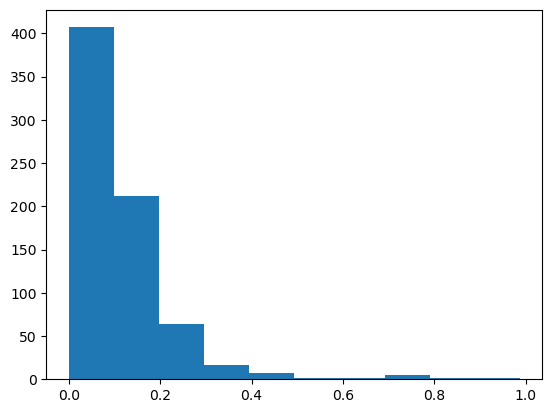

In [269]:
#These are the projects that have over 50% probability of being completed according to the model. 
#Let's join this with the original df.

y_pred = pd.DataFrame(y_pred)
y_pred[y_pred[0] > .3]
plt.hist(y_pred,bins=10)
plt.show()

In [259]:
# calculate the p-values using statsmodels
logit_model = sm.Logit(y_test,X_test).fit()

#result=logit_model.fit()
print(logit_model.summary())

         Current function value: 0.263440
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                 Status   No. Observations:                  718
Model:                          Logit   Df Residuals:                      702
Method:                           MLE   Df Model:                           15
Date:                Tue, 11 Apr 2023   Pseudo R-squ.:                  0.1506
Time:                        12:17:26   Log-Likelihood:                -189.15
converged:                      False   LL-Null:                       -222.68
Covariance Type:            nonrobust   LLR p-value:                 1.483e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.1745      0.296     -3.970      0.000      -1.754      -0.595
x2             0.8104      0.143      5.668      0.000       0.53

/Users/larsenburack/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
